# cTLM analysis script

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
import os

# for bessel functions and curve fitting
from scipy.optimize import curve_fit
from scipy import special

from ipywidgets import interact, fixed
import ipywidgets as widgets
from ipyfilechooser import FileChooser

### read files

In [62]:
# folder_path = r"Data\CTLM Messdaten\[processname=Blauwal][structure=CTLM][ri=103][description=Block1]"
folder_path = r"Data\CTLM Messdaten\[processname=Elefant][structure=CTLM][ri=103][description=Block3]"

r_inner = 103  # in µm

name = os.path.basename(folder_path)
print(name)

list_of_measurements = {}
for file in os.listdir(folder_path):
    if file.endswith('.roh'):
        data = pd.read_csv(os.path.join(folder_path, file), delimiter='\t', skiprows=12, header=1, encoding='ISO-8859-1')
        data['delta_V'] = data['VinS'] - data['VoutS']
        list_of_measurements[int(os.path.splitext(os.path.basename(file))[0])] = data

list_of_measurements = dict(sorted(list_of_measurements.items()))
print(list_of_measurements.keys())

[processname=Elefant][structure=CTLM][ri=103][description=Block3]
dict_keys([4, 24, 44, 64, 94, 120, 140, 160, 180, 200])


### plot all measurements for a quick overview

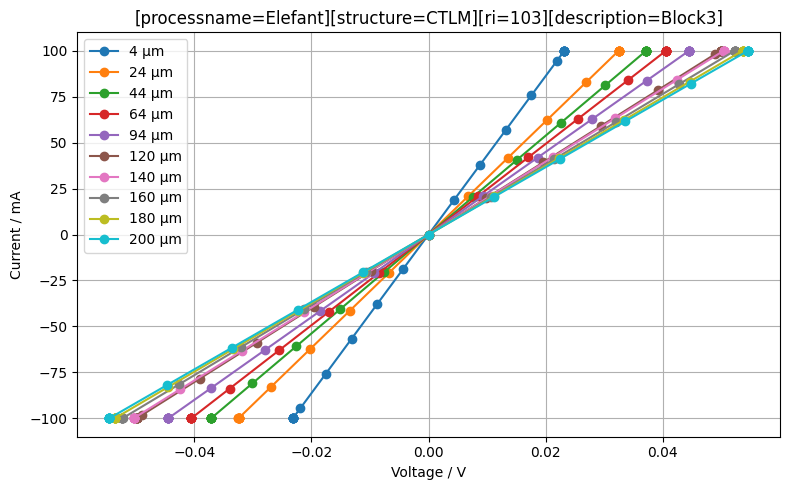

In [63]:
plt.figure(figsize=(8, 5))

for key in list_of_measurements.keys():
    # plt.plot(list_of_measurements[key]['Vin'], list_of_measurements[key]['Iin']*1000, label=key)
    plt.plot(list_of_measurements[key]['delta_V'], list_of_measurements[key]['Iin']*1000, 'o-', label=f"{key} µm")

plt.xlabel("Voltage / V")
plt.ylabel("Current / mA")
# plt.xlim(-0.5, 0.5)
plt.title(name)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(folder_path, 'IV.png'), bbox_inches='tight')

In [45]:
def get_lin_fit(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    y_fit = slope * x + intercept
    r_squared = 1- np.sum((y - y_fit)**2)/(np.sum((y - np.mean(y))**2)) # R^2 = 1 - SS_res / SS_tot = 1 - (y-y_fit)^2/(y-mean(y))^2

    return slope, intercept, r_squared

### check lineartiy of individual measuremnts

In [46]:
def plot_IV(key, plot_data):
    plt.figure(figsize=(8, 5))

    plt.plot(plot_data['delta_V'], plot_data['Iin']*1000, label=f"{key} µm")
    slope, intercept, r_squared = get_lin_fit(list_of_measurements[key]['delta_V'], list_of_measurements[key]['Iin'])
    plt.plot(plot_data['delta_V'], (slope * plot_data['delta_V'] + intercept)*1000, 'r--', label=f'linear fit: R² = {r_squared:.3f}')   # *1000 for mA

    plt.xlabel("Voltage / V")
    plt.ylabel("Current / mA")
    plt.title(name)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return    


keys = list(list_of_measurements.keys())
interact(
    lambda key: plot_IV(keys[key], plot_data=list_of_measurements[keys[key]]),
    key=widgets.IntSlider(min=0, max=len(keys)-1, value=0)
)

interactive(children=(IntSlider(value=0, description='key', max=7), Output()), _dom_classes=('widget-interact'…

<function __main__.<lambda>(key)>

### calcualte TLM values

In [47]:
def get_resistance(list_of_measurements, r_inner):
    R_list = []
    R_corr_list = []
    for key in list_of_measurements.keys():
        slope, intercept, r_squared = get_lin_fit(list_of_measurements[key]['delta_V'], list_of_measurements[key]['Iin'])
        R_list.append((1/slope))  # in ohm
        corr_factor = (r_inner / key) * np.log((r_inner + key) / r_inner)
        # print(corr_factor)
        R_corr_list.append((1/slope)* (1/corr_factor))  # in ohm

    return R_list, R_corr_list

### calculate cTLM values
$L_T$, $R_{sh}$, $R_C$, $\rho_C$


**Fitting Data**

full model: $$ R_{T, \text { circ }}=\frac{R_{s h}}{2 \pi}\left[\ln \left(\frac{r_i+s}{r_i}\right)+\frac{L_t}{r_i} \frac{I_0\left(\frac{r_i}{L_t}\right)}{I_1\left(\frac{r_i}{L_t}\right)}+\frac{L_t}{r_i+s} \frac{K_0\left(\frac{r_i+s}{L_t}\right)}{K_1\left(\frac{r_i+s}{L_t}\right)}\right]$$

Assumtions: 
- radius $r_0 >> L_T$ is small 
- $R_{sh} = R_{sh,c}$ 

simplified: $$R_T=\frac{R_{s h}}{2 \pi}\left[\ln \frac{r_i + d}{r_i}+L_T\left(\frac{1}{r_i +d}+\frac{1}{r_i}\right)\right]$$

$$\begin{split}
R_T &= \mathbf{A} \cdot \ln\left(\frac{r_i + d}{r_i}\right) + \mathbf{B} \cdot \left(\frac{1}{r_i + d} + \frac{1}{r_i}\right)\\
&= A \cdot x_1 + B \cdot x_2
\end{split}$$
$$\mathbf{A} = \frac{R_S}{2\pi}$$
$$\mathbf{B} = \frac{R_S L_T}{2\pi}$$

In [48]:
def get_ctlm_params(slope, intercept, r_inner):
    R_sh = slope * 2 * np.pi * r_inner   # in Ohm/sq
    R_C = intercept / 2 # in Ohm
    
    L_T = intercept / (slope * 2)
    # simple rho_c calculation
    roh_C = (R_sh * (L_T) ** 2) * 1e-8  # 1e-8 to convert from ohm·μm² to ohm·cm²
    
    return R_sh, R_C, L_T, roh_C


# distances, R_list are np.arrays
def fit_linear_approximation(distances, R_list, r_inner):

    R_T = R_list.reshape(-1, 1)  # transpose to column vector
    
    # define column vector for X-matrix
    x1 = np.log((r_inner + distances) / r_inner).reshape(-1, 1)
    x2 = (1/(r_inner + distances) + 1/r_inner).reshape(-1, 1)
    
    X = np.hstack((x1, x2))  # shape (n, 2)
    # print('X_matrix=', X)
    
    # use Linear Least Squares fitting to find the vector [A, B]
    A, B = np.linalg.lstsq(X, R_T, rcond=None)[0]
    
    d_fit = np.arange(0, max(distances), 1)
    # define the fitting function
    R_fit = A * np.log((r_inner + d_fit) / r_inner) + B * (1 / (r_inner + d_fit) + 1 / r_inner) # are those the correct radii?
    
    # get sheet resitance in ohms
    R_sh = A * 2 * np.pi

    # get transfer length in μm
    L_T = (2 * np.pi * B) / R_sh
    
    # get contact resistivity in ohm·μm²
    rho_c = (R_sh * (L_T**2)) * 1e-8  # 1e-8 to convert from ohm·μm² to ohm·cm²
    
    # Use intercept of fit
    R_intercept = (B * 2 )/ r_inner
    
    return d_fit, R_fit, R_sh[0], L_T[0], rho_c[0], R_intercept[0]

### plot TLM

[  4  24  44  64  94 120 140 160 180 200]


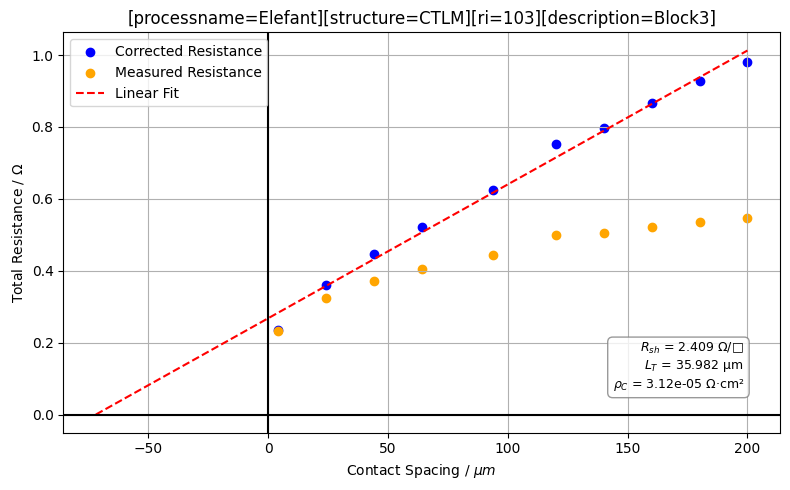

In [ ]:
plt.figure(figsize=(8, 5))

distances = list(map(int, list_of_measurements.keys()))
distances = np.array(distances)
print(distances)

R_list, R_corr_list = get_resistance(list_of_measurements, r_inner)  

# plt.scatter(distances, R_corr_list, marker='o', facecolors='none', edgecolors='red', label='Corrected Resistance')
plt.scatter(distances, R_corr_list,  color='blue', marker='o', label='Corrected Resistance')
plt.scatter(distances, R_list, color='orange', marker='o', label='Measured Resistance')

slope, intercept, r_squared = get_lin_fit(distances, R_corr_list)
R_sh, R_C, L_T, roh_C = get_ctlm_params(slope, intercept, r_inner)

x_fit_extended = np.linspace(-intercept/slope, distances.max(), 200) # extend x-axis for better visualization
plt.plot(x_fit_extended, (slope * x_fit_extended + intercept), 'r--', label='Linear Fit')


tlm_text = (
    f"$R_{{sh}}$ = {R_sh:.3f} Ω/□\n"
    f"$L_T$ = {L_T:.3f} µm\n"
    f"$\\rho_C$ = {roh_C:.2e} Ω·cm²"
)

plt.gca().text(
    0.95, 0.1, tlm_text,
    fontsize=9,
    transform=plt.gca().transAxes,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)

plt.title(name)
plt.xlabel("Contact Spacing / $\\mu m$")
plt.ylabel("Total Resistance / $\\Omega$")
plt.legend()
plt.tight_layout()
# plt.xlim(0, max(list_of_measurements.keys())+20)
plt.grid(True)
# plt.savefig(f"Output/{name}_linear.png")
plt.show()

# print('### simple correction model:')
# print(f"Sheet Resistance (R_sh): {R_sh:.4f} Ohms/sq")
# print(f"Contact Resistance (R_C): {R_C:.4f} Ohms")
# print(f"Transfer Length (L_T): {L_T:.4f} μm")
# print(f"Contact Resistivity (rho_C): {roh_C:.2e} Ohm·cm²")

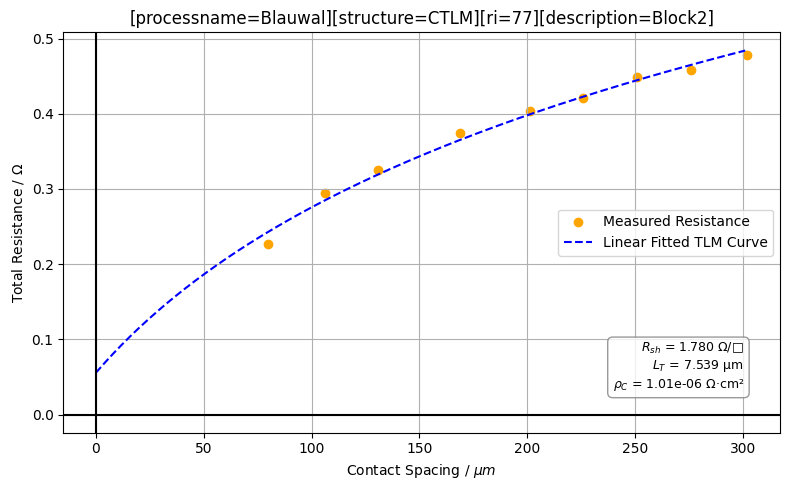

In [19]:
plt.figure(figsize=(8, 5))

distances = list(map(int, list_of_measurements.keys()))
distances = np.array(distances)

R_list, R_corr_list = get_resistance(list_of_measurements, r_inner)  

plt.scatter(distances, R_list, color='orange', marker='o', label='Measured Resistance')

d_fit, R_fit, R_sh_linear, L_T_linear, rho_C_linear, R_intercept = fit_linear_approximation(distances, np.array(R_list), r_inner)

plt.plot(d_fit, R_fit, color='blue', linestyle='--', label='Linear Fitted TLM Curve')


tlm_text = (
    f"$R_{{sh}}$ = {R_sh_linear:.3f} Ω/□\n"
    f"$L_T$ = {L_T_linear:.3f} µm\n"
    f"$\\rho_C$ = {rho_C_linear:.2e} Ω·cm²"
)

plt.gca().text(
    0.95, 0.1, tlm_text,
    fontsize=9,
    transform=plt.gca().transAxes,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)

plt.title(name)
plt.xlabel("Contact Spacing / $\\mu m$")
plt.ylabel("Total Resistance / $\\Omega$")
plt.legend()
plt.tight_layout()
# plt.xlim(0, max(list_of_measurements.keys())+20)
plt.grid(True)
plt.show()

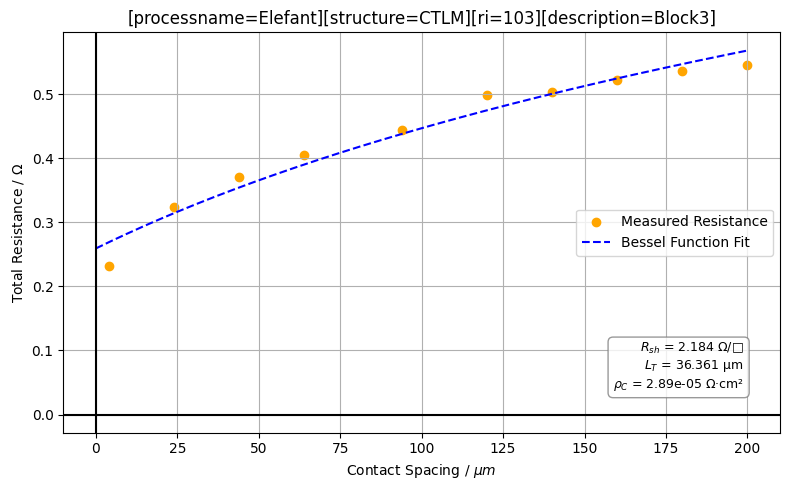

In [ ]:
# @param distances: array of contact spacings
# @param r_inner: inner radius of the CTLM structure
# @param Rsh: sheet resistance -> initial guess
# @param Lt: transfer length -> initial guess
# this still uses the assumption of R_sh being constant under and between the contacts
def ctlm_bessel_model(geometries, Rsh, L_T):
        
        (distances, r_inner) = geometries
        # Term 1: Resistance of the semiconductor gap
        term_gap = np.log((r_inner + distances) / r_inner)
        
        # Term 2: Resistance of the inner contact (using using bessel functions I0 and I1)
        term_inner = (L_T / r_inner) * (special.i0(r_inner / L_T) / special.i1(r_inner / L_T))
        
        # Term 3: Resistance of the outer contact (using bessel functions K0 and K1)
        term_outer = (L_T / (r_inner + distances)) * (special.k0((r_inner + distances) / L_T) / special.k1((r_inner + distances) / L_T))
        
        # Total Resistance
        R_T = (Rsh / (2 * np.pi)) * (term_gap + term_inner + term_outer)

        return R_T

# function for fitting the full bessel function model for the total resistance
def fit_bessel_model(distances, r_inner, R_list, Rsh, L_T):   
    
    popt, pcov = curve_fit(ctlm_bessel_model, (distances, r_inner), R_list, p0=[Rsh, L_T], bounds=([0, 0], [np.inf, np.inf]))

    Rsh_fit, Lt_fit = popt

    rho_c = Rsh_fit * (Lt_fit**2) * 1e-8  # 1e-8 to convert from ohm·μm² to ohm·cm²

    return Rsh_fit, Lt_fit, rho_c

r_inner_array = np.full_like(distances, r_inner)
Rsh_fit, Lt_fit, rho_c_fit = fit_bessel_model(distances=distances, r_inner=r_inner_array, R_list=R_list, Rsh=R_sh_linear, L_T=L_T_linear)

distances_smooth = np.linspace(0, max(distances), 300) # min(distances)
ri_smooth = np.full_like(distances_smooth, r_inner)
Rt_fit_curve = ctlm_bessel_model((distances_smooth, ri_smooth), Rsh_fit, Lt_fit)


plt.figure(figsize=(8, 5))

plt.scatter(distances, R_list, color='orange', marker='o', label='Measured Resistance')
plt.plot(distances_smooth, Rt_fit_curve, color='blue', linestyle='--', label='Bessel Function Fit')

d_fit, R_fit, R_sh_linFit, L_T_linFit, rho_C_linFit, R_intercept = fit_linear_approximation(distances, np.array(R_list), r_inner)
# plt.plot(d_fit, R_fit, color='green', linestyle='--', label='Linear Approximated Fit')

tlm_text = (
    f"$R_{{sh}}$ = {Rsh_fit:.3f} Ω/□\n"
    f"$L_T$ = {Lt_fit:.3f} µm\n"
    f"$\\rho_C$ = {rho_c_fit:.2e} Ω·cm²"
)

plt.gca().text(
    0.95, 0.1, tlm_text,
    fontsize=9,
    transform=plt.gca().transAxes,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)

plt.title(name)
plt.xlabel("Contact Spacing / $\\mu m$")
plt.ylabel("Total Resistance / $\\Omega$")
plt.legend()
plt.tight_layout()
# plt.xlim(0, max(list_of_measurements.keys())+20)
plt.grid(True)
# plt.savefig(f'Output/{name}_bessel.png')
plt.show()

In [71]:
# compare results from all models:
results_df = pd.DataFrame(columns=['Value', 'Simple Linear Correction', 'Linear Approximated Model', 'Bessel'])
results_df['Value'] = ['Sheet Resistance (R_sh) [Ohms/sq]', 'Transfer Length (L_T) [μm]', 'Contact Resistivity (rho_C) [Ohm·cm²]']
results_df['Simple Linear Correction'] = [R_sh, L_T, roh_C]
results_df['Linear Approximated Model'] = [R_sh_linear, L_T_linear, rho_C_linear]
results_df['Bessel'] = [Rsh_fit, Lt_fit, rho_c_fit]
results_df

,Value,Simple Linear Correction,Linear Approximated Model,Bessel
0,Sheet Resistance (R_sh) [Ohms/sq],1.804084,1.779939,1.776534e+00
1,Transfer Length (L_T) [μm],8.248175,7.538576,7.424147e+00
2,Contact Resistivity (rho_C) [Ohm·cm²],0.000001,0.000001,9.791896e-07
